In [1]:
# %load ../../preconfig.py
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.rcParams['axes.grid'] = False

import numpy as np
#import pandas as pd

#import sklearn

#import itertools

import logging
logger = logging.getLogger()


2 MapReduce and the New Software Stack
=====================

"big-data" analysis:

1. manage immense amounts of data quickly.

2. data is extremely regular $\to$ exploit parallelism.

new software stack:     
"distributed file system" $\to$ MapReduce

When designing MapReduce algorithms, we often find that the greatest cost is in the communication.

### 2.1 Distributed File Systems
commodity hardware + network

#### 2.1.1 Physical Organization of Compute Nodes
*cluster computing*: the new parallel-computing architecture.

*racks*: compute nodes are stored on racks.

communication:

1. The nodes on a single rack are connected by a network, typically gigabit Ethernet. And racks are connected by another level of network or a switch.

2. The bandwidth of *inter-rack* communication is somewhat greater than the *intrarack* Ethernet.

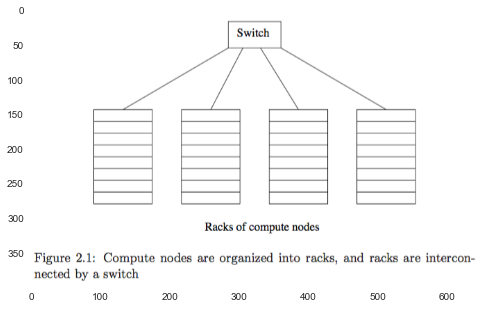

In [3]:
plt.imshow(plt.imread('./res/fig2_1.png'))

the solution for components failure (loss of node or rack):

1. Files must be stored redundantly.

2. Computations must be divided into tasks.

#### 2.1.2 Large-Scale File-System Organization
DFS: distributed file system

1. Google File System (GFS)

2. Hadoop Distributed File System (HDFS)

3. CloudStore

It is typically used as follows:

1. Files can be enormous, possibly a terabyte in size.

2. Files are rarely updated.

manage:

1. Files are divided into chunks.       
   Chunks are replicated at different compute nodes of different racks.
   
2. *master node* or *name node*: another small file to find the chunks of a file.
   master node is iteself replicated, and a directory for the file systme as a whole knows where to find its copies.      
   The directory itself can be replicated, and all participants using the DFS know where the directory copies are.

### 2.2 MapReduce
All you need to write are two functions, called Map and Reduce.

a MapReduce computation executes as follows:

1. Map function: Map tasks turn the chunk given into a sequence of *key-value* pairs.

2. The key-value pairs from each Map task are collected by a *master controller* and sorted by key.     
   divide by key: all pairs with same key $\to$ same Reduce task.
   
3. Reduce function: The Reduce tasks work on one key at a time, and combine all the values associated with that key in some way.

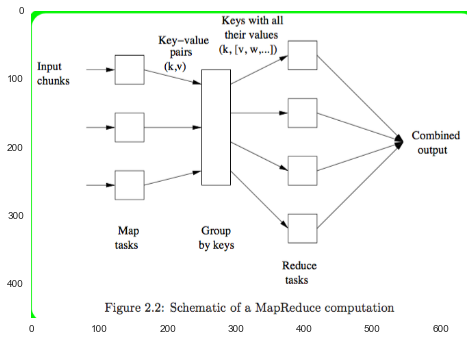

In [4]:
plt.imshow(plt.imread('./res/fig2_2.png'))

#### 2.2.1 The Map Tasks
The Map function takes an input element as its argument and produces zero or more key-value pairs.

#### 2.2.2 Grouping by Key
Group: the key-value pairs are groued by key, which is performed by the system.

partition: hash keys to reduce tasks.

#### 2.2.3 The Reduce Tasks
reducer: the application of the Reduce function to a single key and its associated list of values.

a Reduce task executes one or more reducers.

why not to execute each reducer a separate Reduce task for maximum parallelism?

+ There is overhead associated with each task we create.     
  number of Reduce tasks $<$ number of reducers.

+ There is often significant variation in the lengths of the value lists for different keys, so different reducers take different amount of time. $\to$ skew.      
  if keys are sent randomly to less Reduce tasks $\to$ expect that time is average. $\to$ number of Reduce tasks $<$ compute nodes.

#### 2.2.4 Combiners
If a Reduce function is associative and commutative, (the values to be combined can be combined in any order, with the same result), we can push some of what the reducers do to the Map tasks (combiner).

#### 2.2.5 Details of MapReduce Execution

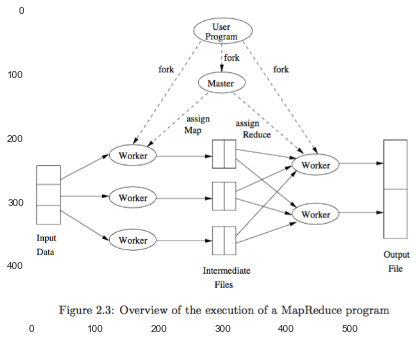

In [2]:
plt.imshow(plt.imread('./res/fig2_3.png'))

#### 2.2.6 Coping With Node Failures
1. Master fails $\to$ restart.

2. Map worker fails $\to$ all the Map tasks assigned to the worker will have to redone. and also inform each Reduce task about the change.

3. Reduce worker fails. $\to$ resheduled on another reduce worker later.

#### 2.2.7 Exercises for Section 2.2
##### (a)
Yes, significant skew exists. The word frequent is not equal in text.

##### (b)
the skew should be insignificant.      

10,000 more significant.

##### (c)

combiner can help reduce skew.

### 2.3 Algorithms Using MapReduce
Operations that can use MapReduce effectively:

1. very large matrix-vector multiplicatons

2. relational-algebra opertions

#### 2.3.1 Matrix-Vector Multiplication by MapReduce
\begin{align}
    \mathbf{X}_{1 \times n} &= \mathbf{M}_{n \times n} \mathbf{v}_{1 \times n} \\
    x_i &= \displaystyle \sum_{j=1}^n m_{ij} v_j 
\end{align}

We first assume that $n$ is large, but not so larget that $\mathbf{v}$ cannot fit in main memory and thus be available to every Map task.

+ Map:
  1. read $\mathbf{v}$.
  2. produces $(i, m_{ij} v_j)$
  
+ Reduce:
  simply sums all the values and produces pair $(i, x_i)$.

#### 2.3.2 If the Vector $\mathbf{v}$ Cannot Fit in Main Memory
We can divide the matrix into vertical *stripes* of equal width and divide the vector into an equal number of horizontal stripes, of the same height.

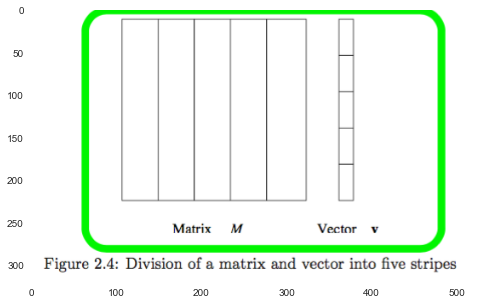

In [3]:
plt.imshow(plt.imread('./res/fig2_4.png'))

Each Map task is assigned a chunk from one of the stripes of the matrix and gets the entire corresponding stripe of the vector.

particular application (PageRank calculation) has an additional constraint that the result vector should be partitioned in the same way as the input vector.

We shall see there that the best strategy involves partitioning the matrix $\mathbf{M}$ into square blocks, rahter than stripes.

#### 2.3.3 Relational-Algebra Operations
There are many operations on data that can be described easily in terms of the common database-query primitives.

a *relation* is a table with column headers called *attributes*.

Rows of the relation are called *tuples*.

The set of attributes of a relation is called its *schema*.

$R(A_1, A_2, \dotsc, A_n)$: the relation name is $R$ and its attributes are $A_1, A_2, \dotsc, A_n$.

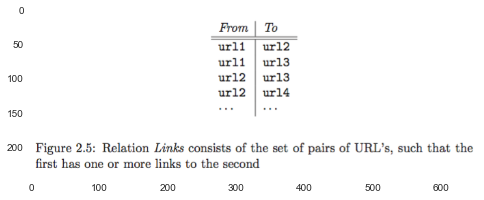

In [4]:
plt.imshow(plt.imread('./res/fig2_5.png'))

*relational algebra*: several standard operations on relations.

1. Selection $\sigma{C} (R)$: select tuples that satisfy $C$
   + **Map**: produce $(t, t)$ if $t$ satisfies $C$ where $t \in R$.
   + **Reduce**: simple passes each key-value pair to the output.

2. Projection $\pi_{S} (R)$: produces subset $S$ of the attributed
   + **Map**: output $(t', t')$ where $t'$ is subset of $t$.
   + **Reduce**: eliminate duplicates, turns $(t', [t', t', \dotsc, t'])$ into $(t', t')$.
     associative and commutative $\to$ combiner

3. Union, Intersection, and Difference
   1. Union:
      + **Map**: turn $t$ into $(t, t)$.
      + **Reduce**: Produce $(t, t)$ for input $(t, [t])$ or $(t, [t, t])$.
      
   2. Intersection:
      + **Map**: turn $t$ into $(t, t)$.
      + **Reduce**: produce $(t, t)$ if input $(t, [t, t])$.
      
   3. Difference $S - R$:
      + **Map**: produce $(t, R)$ where $t \in R$, or $(t, S)$ where $t \in S$.
      + **Reduce**: produce $(t, t)$ if input $(t, [R])$.

4. Natural Join $R \bowtie S$ 
   + **Map**: produce $(b, (R, a))$ for $(a, b) \in R$, or $(b, (S, c))$ for $(b, c) \in S$.
   + **Reduce**: $(a, b, c)$ when input $(b, [(R, a), (S, c)])$.

5. Grouping and Aggregation $\gamma_{X} (R)$:
   where $X$ consists of:
   + a grouping attribute,
   + an expression $\theta(A)$
   
   Let $R(A, B, C)$, for $\gamma_{A, \theta(B)} (R)$:
   + **Map**: produce $(a, b)$ for each tuple $(a, b, c)$.
   + **Reduce**: apply the aggregation operator $\theta$ to the list $[b_1, b_2, \dotsc, b_n]$ of B-values associated with key $a$.

#### 2.3.9 Matrix Multiplication

$\mathbf{M} \times \mathbf{N}$

grouping and aggregation

##### two MapReduce step
1. 1st MapReduce
   + **Map**: $(j, (M, i, m_{ij}))$ and $(j, (N, k, n_{jk}))$.
   + **Reduce**: $((i, k), m_{ij} n_{jk})$ for its associated values of each key $j$.
   
2. 2nd MapReduce
   + **Map**: identity
   + **Reduce**: for each key $(i, k)$, produce the sum of the list of values associated with this key.
   
##### one MapReduce step
+ **Map**:
  - for each $m_{ij}$, produce all pairs $((i, k), (M, j, m_{ij}))$ for $k = 1, 2, \dotsc$.     
  - for each $n_{jk}$, produce all pairs $((i, k), (N, j, n_{jk}))$ for $i = 1, 2, \dotsc$.
  
+ **Reduce**:
  Each key $(i, k)$ will have an associated list with all the values $(M, j, m_{ij})$ and $(N, j, n_{jk})$, for all possible values of $j$.
  - connect the two values on the list that have the same values of $j$: An easy way to do this step is to sort by $j$ the values.
  - then multiply and sum.

#### 2.3.11 Exercises for Section 2.3
Ex 2.3.5

### 2.4 Extensions to MapReduce
some extensions and modifications, share the same characteristics:
1. built on a distributed file system.
2. very large numbers of tasks, and a small number of user-written functions.
3. dealing with most of the failures without restart.

#### 2.4.1 Workflow Systems
idea: two-step workflow (Map, Reduce) $\to$ any collection of functions

two experimental systems
+ Clustera
+ Hyracks

advantage: without need to store the temporary file that is output of one MapReduce job in the distributed file system.

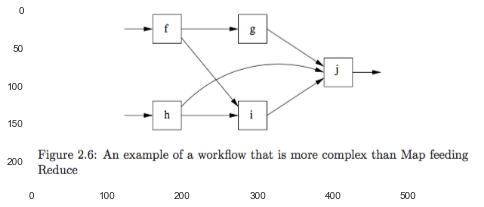

In [3]:
plt.imshow(plt.imread('./res/fig2_6.png'))

#### 2.4.2 Recursive Extensions to MapReduce
Many large-scale computations are really recursions.

mutually recursive tasks: modify input (flow graphs that are not acyclic), so it is not feasible to simple start when some node failed.

**solution A**: split to two step $\to$ backup data

Example 2.6

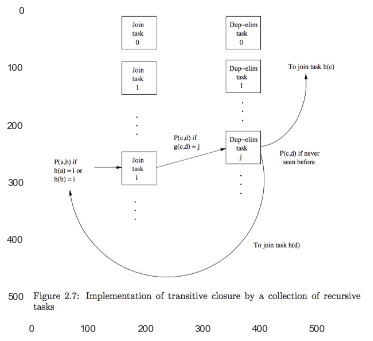

In [4]:
plt.imshow(plt.imread('./res/fig2_7.png'))

#### 2.4.3 Pregel
**solution B**: backup entire stats of each task **checkpoints**, so recovery the backup point if fail.

checkpoints is triggered at fixed *supersteps*.

#### 2.4.4 Exercises for Section 2.4
###### Ex 2.4.1
for the prob of a taks, success is $(1-p)^t$, fail is $(1 - (1 - p)^t)$ . So the expected execution time of a task is $(1-p)^t t  + (1 - (1-p)^t) 10 t = 10t - 9t(1-p)^t$.

Thus, total expected time is $n(10t - 9t (1-p)^t) = nt(10 - 9 (1-p)^t)$.

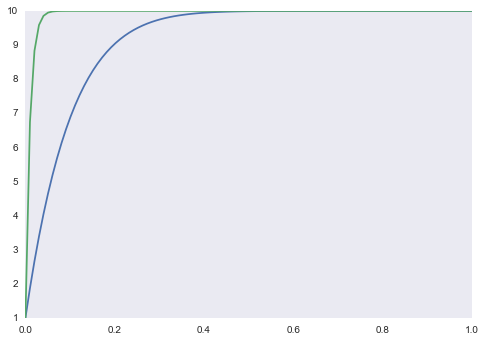

In [13]:
def calc_prob(p, t):
    return 10 - 9 * ((1 - p)**t)

p = np.linspace(0, 1, 100)

y1 = calc_prob(p, 10)
y2 = calc_prob(p, 100)
plt.plot(p, y1, 'b', p, y2, 'g')

###### Ex 2.4.2
suppose that supersteps should be $n$, the time of one execting a superstep is $t$.



### 2.5 The Communication Cost Model
for many applications, the bottleneck is moving data among tasks.

#### 2.5.1 Communication-Cost for Task Networks
The *communication cost* of a task is the size of the input to the task. we shall often use the number of tuples as a measure size, rather than bytes.

The *communication cost* of an algorithm is the sum of the communication cost of all the tasks implementing that algorithm. We shall focus on the communication cost as the way to measure the efficiency of an algorithm, since the exceptions, where execution time of tasks dominates, are rare in practice.

We count only input size, and not output size.

#### 2.5.2 Wall-Clock Time
Besides communication cost, we must also be aware of the importance of *wall-clock time*, the time it takes a prallel algorithm to finish.

The algorithms shall have the property that the work is divided fairly among the tasks.

#### 2.5.3 Multiway Joins
example: $R(A, B) \bowtie S(B, C) \bowtie T(C, D)$.

Suppose that the relation $R, S, T$ have sizes $r, s$, and $t$, respectively. and for simplicity, suppose $p$ is the probability that any two tuples in each relations agree on the item they share.

##### Solution 1: general theory
$\operatorname{join} \left ( \operatorname{join} \left ( R(A, B) \bowtie S(B, C) \right ) \bowtie T(C, D) \right )$
or exchange the sequence of join.

1. 1st MapReduce
   $\operatorname{join} \left ( R(A, B) \bowtie S(B, C) \right )$
   $O(t + prs)$

2. 2nd MapReduce
   $O(r + s + t + prs)$
   

##### Solution 2: use a single MapReduce job that joins the three relations at once.

Assume: 

+ We plan to use $k$ reducers for the job.

+ $b, c$ represents the number of buckets into which we shall hash $B-$ and $C-$values, respectively.

  - $h(B) \to b$.
  
  - $g(C) \to c$.
  
  we require $b c = k$.
  
So, the reducer corresponding to bucket pair $(i, j)$ is responsible for joining the tuples $R(u, v), S(v, w)$, and $T(w, x)$ whenever $h(v) = i$ and $g(w) = j$.

1. $S(v, w)$ to reducer $(h(v), g(w))$.
   communication cost: $s$

2. $R(u, v)$ to $c$ reducers $(h(v), c)$.
   communication cost: $c r$

3. $T(w, x)$ to $b$ reducers $(b, g(w))$.
   communication cost: $b t$
   
There is also a *fixed* cost $r + s + t$ to make each tuple of each relation be input to one of the Map tasks.

The problem arises:
$$\operatorname{arg \, min}_{b, c} s + cr + bt \text{where} bc = k$$
We get the solution: $c = \sqrt{kt / r}$ and $b = \sqrt{kr / t}$. So $s + cr + bt  = s  + 2 \sqrt{k r t}$. 

In all, the total communication cost is $r + 2s + t + 2 \sqrt{k r t}$.

####  2.5.4 Exercises for Section 2.5
`#todo`

### 2.6 Complexity Theory for MapReduce
our desire in the section:

+ to shrink the wall-clock time

+ to execute each reducer in main memory

#### 2.6.1 Reducer Size and Replication Rate
two parameters that characterize families of MapReduce algorithms:

1. **reducer size**$q$: the upper bound on the number of values that are allowed to appear in the list associated with a single key.
   It can be selected with at least two goals in mind:
   1. By making the reducer size small $\to$ we get many reducers.
   2. By making the reducer size small $\to$ computation in reducer can be exected entirely in the main memory.
   
2. **replication rate**$r$: the number of key-value pairs producted by all the Map tasks on all the inputs, divided by the number of inputs. It is the average communication from Map tasks to Reduce tasks per input.

#### 2.6.2 An Example: Similarity Joins
we are given a large set of element $X$ and a similarity measure $s(x, y)$ which is symmetric. The output of the algorithm is those pairs whose similarity exceeds a given threshold $t$.     

eg: discover similar images in a collection of one million images.    
solution:
1. $(\{i, j\}, [P_i, P_j])$
   this algorithm will fail completely:
   the reducer size is small, however, the replication rate is 999,999 $\to$ the communication cost is extremelly large.
   
2. We can group pictures into $g$ groups, each of $10^6 / g$ pictures.

#### 2.6.3 A Graph Model for MapReduce Problems
In this section, we hope to prove lower bounds on the replication rate. The first step is to introduce a graph model of problems.

For each problem solvable by a MapReduce algorithm there is:

1. A set of inputs.

2. A set of outputs.

3. A many-many relationship between the inputs and outputs, which describes which inputs are necessary to produce which outputs.

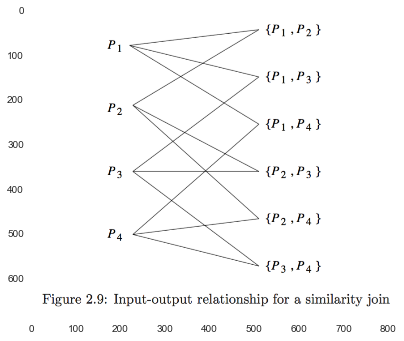

In [3]:
plt.imshow(plt.imread('./res/fig2_9.png'))

#### 2.6.4 Mapping Schemas
*mapping schema* expresses how outputs are produced by the various reducers. 

A mapping schema for a given problem with a given reducer size $q$ is an assignment of inputs to one or more reducers, such that:

1. No reducer is assigned more than $q$ inputs.

2. For every output of the problem, there is at least one reducer that is assigned all the inputs that are related to that output. We say this reducer *covers* the output.

#### 2.6.5 When Not All Inputs Are Present
The only way the absense of some inputs makes a difference is that we may wish to rethink the desired value of the reducer size $q$ when we select an algorithm from the family of possible algorithms.

#### 2.6.6 Lower Bounds on Replication Rate
minimum possible communication is known if we can prove a matching lower bound.

Here is an outline of the technique:

1. Prove an upper bound $g(q)$ on how many outputs a reducer with $q$ inputs can cover.

2. Determine the total number of outputs produced by the problem.

3. Suppose that there are $k$ reducers, and the $i$th reducer has $q_i < q$ inputs. 
   Observe that $\sum_{i=1}^k g(q_i)$ must be no less than the number of outputs computed in step (2).
   
4. Manipulate the inequality from (3) to get a lower bound on $\sum_{i=1}^k q_i$.
   Often, the trick used is to replace some factors of $q_i$ by their upper bound $q$, but leave a single factor of $q_i$ in the term for $i$.
   
5. Since $\sum_{i=1}^k q_i$ is the total communication from Map tasks to Reduce tasks, divide to lower bound from (4) on this quantity by the number of inputs.
   The result is a lower bound on the replication rate.

#### 2.6.7 Case Study: Matrix Multiplication

#### 2.6.8 Exercises for Section 2.6